### Titanic survivor prediction

Trying to achieve a good score at the kaggle competion

Points to consider:
- **What to do with the missing values**
    - 1. fill with some values
        - mean, meadian,mode, some conditional values based on other features
    - 2. drop the feature with missing value
    - 3. make a new feature out of the existing feature having missing value
- **Make new features out of existing features**
    - 1. SibSp and Parch
    - 2. Cabin - isna
    - 3. Title from Name
- **Whether to bin some of the features**
    - 1. Age
    - 2. Fare
- **Use minmax scaler/ standard scalar**
- **Use feature selection**
- **Which models to use for prediction**
- **Hypertune**
- **Stacking the models**


### In this notebook we have 3 testcases for 3 models building on previous resutls(tc_7 to tc_9)

- filling age with mean of the group of Pclass,Sex and Title
- making bins of age
- **making bins of fare**
- dropping cabin
- extracting title from name
- extracting the first letter from ticket
- filling embarked with mode 
- 3 models used RF, LR, XGBoost
#### result
#### 0.8013
#### 0.78229
#### 0.78947

In [1]:
import pandas as pd
import numpy as np

In [2]:
# importing data from csv files
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df_train.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


In [4]:
# combining the test and train to fill the missing values
comb = df_train.append(df_test)
comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


## Name

Extracting the titles from the name feature
and dropping the name field



In [5]:
comb['Title'] = comb.Name.str.extract(pat = ' ([A-Za-z]+)\.',expand = False)
''' Expand :If True, return DataFrame with one column per capture group. 
            If False, return a Series/Index if there is one capture group or DataFrame 
            if there are multiple capture groups.
'''
type(comb['Title'])

pandas.core.series.Series

In [6]:
# dropping the name feature
comb.drop('Name',inplace = True,axis = 1)
comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
 11  Title        1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


## Age

Filling the missing values with median age

In [7]:
comb.Age.isnull().sum()

263

In [8]:
age_median = comb.groupby(['Pclass','Title','Sex'])['Age'].median().reset_index(['Pclass','Title','Sex'])
age_median

,Pclass,Title,Sex,Age
0,1,Capt,male,70.0
1,1,Col,male,54.5
2,1,Countess,female,33.0
3,1,Don,male,40.0
4,1,Dona,female,39.0
5,1,Dr,female,49.0
6,1,Dr,male,47.0
7,1,Jonkheer,male,38.0
8,1,Lady,female,48.0
9,1,Major,male,48.5


In [9]:
age_median[(age_median.Title == 'Ms') & (age_median.Pclass == 2)]['Age'].values[0]

28.0

In [10]:
def get_age(x):
    return age_median[(age_median.Title == x.Title) & \
                      (age_median.Pclass == x.Pclass) & \
                      (age_median.Sex == x.Sex)]['Age'].values[0]


In [11]:
comb.Age = comb.apply(lambda row: get_age(row) if np.isnan(row['Age']) else row['Age'] , axis = 1)
comb.Age.isnull().sum()

1

In [12]:
comb.Age.isnull().sum()

1

In [13]:
comb[comb.Age.isnull()]


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
88,980,NaN,3,female,NaN,0,0,364856,7.75,NaN,Q,Ms


In [14]:
## we fill this value witb median of Pclass 2,Ms as 28
comb.Age.fillna(28,inplace =  True)
comb.Age.isnull().sum()

0

In [15]:
# binning the age
bins= [0,2,4,13,20,75,110]
labels = ['Infant','Toddler','Kid','Teen','Adult','Elderly']
comb['AgeGroup'] = pd.cut(comb['Age'], bins=bins, labels=labels, right=False)


In [16]:
#dropping the Age feature
comb.drop('Age',inplace = True, axis = 1)

## Ticket
Extracting the first letter of the ticket


In [17]:
comb.Ticket

0               A/5 21171
1                PC 17599
2        STON/O2. 3101282
3                  113803
4                  373450
              ...        
413             A.5. 3236
414              PC 17758
415    SOTON/O.Q. 3101262
416                359309
417                  2668
Name: Ticket, Length: 1309, dtype: object

In [18]:
# observing the pattern
comb.groupby('Ticket').count()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Cabin,Embarked,Title,AgeGroup
Ticket,,,,,,,,,,,
110152,3,3,3,3,3,3,3,3,3,3,3
110413,3,3,3,3,3,3,3,3,3,3,3
110465,2,2,2,2,2,2,2,2,2,2,2
110469,1,0,1,1,1,1,1,1,1,1,1
110489,1,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
W./C. 6608,5,4,5,5,5,5,5,0,5,5,5
W./C. 6609,1,1,1,1,1,1,1,0,1,1,1
W.E.P. 5734,2,1,2,2,2,2,2,2,2,2,2


In [19]:
'''
We observe that some ticket numbers are digits while ohters have an alphabet in the begining.
We use this feature, to keep the first letter of the ticket and insert a 'Z' for the digits only

'''
comb.Ticket = comb.Ticket.map(lambda x: 'Z' if x.isdigit() else x[0] )

In [20]:
comb.groupby('Ticket')['PassengerId'].count()

Ticket
A     42
C     77
F     13
L      5
P     98
S     98
W     19
Z    957
Name: PassengerId, dtype: int64

## Fare
Filling the missing value with mode


In [21]:
comb.Fare.isnull().sum()

1

In [22]:
# filling the. Fare with mode value
comb.Fare.fillna(comb.Fare.mode()[0], inplace = True)
comb.Fare.isnull().sum()

0

In [23]:
# getting the max and min of fare to make the bins
print(comb.Fare.max(),comb.Fare.min())

512.3292 0.0


In [24]:
comb.groupby('Fare')['Fare'].count()


Fare
0.0000      17
3.1708       1
4.0125       1
5.0000       1
6.2375       1
            ..
227.5250     5
247.5208     3
262.3750     7
263.0000     6
512.3292     4
Name: Fare, Length: 281, dtype: int64

In [25]:
comb

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup
0,1,0.0,3,male,1,0,A,7.2500,NaN,S,Mr,Adult
1,2,1.0,1,female,1,0,P,71.2833,C85,C,Mrs,Adult
2,3,1.0,3,female,0,0,S,7.9250,NaN,S,Miss,Adult
3,4,1.0,1,female,1,0,Z,53.1000,C123,S,Mrs,Adult
4,5,0.0,3,male,0,0,Z,8.0500,NaN,S,Mr,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,male,0,0,A,8.0500,NaN,S,Mr,Adult
414,1306,NaN,1,female,0,0,P,108.9000,C105,C,Dona,Adult
415,1307,NaN,3,male,0,0,S,7.2500,NaN,S,Mr,Adult
416,1308,NaN,3,male,0,0,Z,8.0500,NaN,S,Mr,Adult


<AxesSubplot: xlabel='Fare', ylabel='Count'>

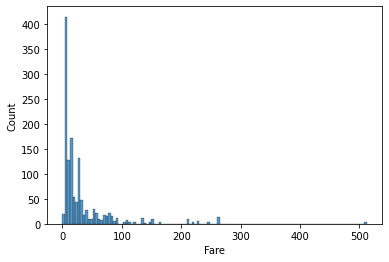

In [26]:
import seaborn as sns
temp = comb.reset_index(drop = True)
sns.histplot(data = temp, x = 'Fare')

In [27]:
#
# bins= [0,10,20,30,40,50,60,70,80,90,100,200,600]
# labels = ['fare1','fare2','fare3','fare4','fare5','fare6','fare7','fare8','fare9','fare10','fare11','fare12']
# comb['FareGroup'] = pd.cut(comb['Fare'], bins=bins, labels=labels, right=False)
# # 0.78229
# # 0.77751
# # 0.77751

In [28]:
# bins= [0,20,40,60,80,100,200,600]
# labels = ['fare1','fare2','fare3','fare4','fare5','fare6','fare7']
# comb['FareGroup'] = pd.cut(comb['Fare'], bins=bins, labels=labels, right=False)
# result
# 0.79425
# 0.78708
# 0.7799

In [29]:
# binning the Fare values
bins= [0,40,80,120,200,600]
labels = ['fare1','fare2','fare3','fare4','fare5']
comb['FareGroup'] = pd.cut(comb['Fare'], bins=bins, labels=labels, right=False)
# result
# 0.8013
# 0.78229
# 0.78947

In [30]:
comb

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,FareGroup
0,1,0.0,3,male,1,0,A,7.2500,NaN,S,Mr,Adult,fare1
1,2,1.0,1,female,1,0,P,71.2833,C85,C,Mrs,Adult,fare2
2,3,1.0,3,female,0,0,S,7.9250,NaN,S,Miss,Adult,fare1
3,4,1.0,1,female,1,0,Z,53.1000,C123,S,Mrs,Adult,fare2
4,5,0.0,3,male,0,0,Z,8.0500,NaN,S,Mr,Adult,fare1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,male,0,0,A,8.0500,NaN,S,Mr,Adult,fare1
414,1306,NaN,1,female,0,0,P,108.9000,C105,C,Dona,Adult,fare3
415,1307,NaN,3,male,0,0,S,7.2500,NaN,S,Mr,Adult,fare1
416,1308,NaN,3,male,0,0,Z,8.0500,NaN,S,Mr,Adult,fare1


In [31]:
# dropping the Fare feature
comb.drop(['Fare'],inplace = True, axis = 1)
comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1309 non-null   int64   
 1   Survived     891 non-null    float64 
 2   Pclass       1309 non-null   int64   
 3   Sex          1309 non-null   object  
 4   SibSp        1309 non-null   int64   
 5   Parch        1309 non-null   int64   
 6   Ticket       1309 non-null   object  
 7   Cabin        295 non-null    object  
 8   Embarked     1307 non-null   object  
 9   Title        1309 non-null   object  
 10  AgeGroup     1309 non-null   category
 11  FareGroup    1309 non-null   category
dtypes: category(2), float64(1), int64(4), object(5)
memory usage: 115.5+ KB


## Cabin 
Dropping the feature as it has many missing values


In [32]:
comb.drop(['Cabin'],axis = 1,inplace = True)
comb.head(3)

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Ticket,Embarked,Title,AgeGroup,FareGroup
0,1,0.0,3,male,1,0,A,S,Mr,Adult,fare1
1,2,1.0,1,female,1,0,P,C,Mrs,Adult,fare2
2,3,1.0,3,female,0,0,S,S,Miss,Adult,fare1


## Embarked
Filling the missing value with mode

In [33]:
comb.Embarked.isnull().sum()

2

In [34]:

# we first fill embarked with mode value
comb.Embarked.fillna(comb.Embarked.mode()[0], inplace = True)
comb.Embarked.isnull().sum()

0

In [35]:
comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1309 non-null   int64   
 1   Survived     891 non-null    float64 
 2   Pclass       1309 non-null   int64   
 3   Sex          1309 non-null   object  
 4   SibSp        1309 non-null   int64   
 5   Parch        1309 non-null   int64   
 6   Ticket       1309 non-null   object  
 7   Embarked     1309 non-null   object  
 8   Title        1309 non-null   object  
 9   AgeGroup     1309 non-null   category
 10  FareGroup    1309 non-null   category
dtypes: category(2), float64(1), int64(4), object(4)
memory usage: 105.2+ KB


## One hot encoding the the categorical features


In [36]:
categorical_feature = comb.select_dtypes(include=['object','category']).columns.tolist()
categorical_feature

['Sex', 'Ticket', 'Embarked', 'Title', 'AgeGroup', 'FareGroup']

In [37]:
# we include Pclass and parch and sibsp too in the one hot encodeing list
categorical_feature += ['Pclass','Parch','SibSp']
categorical_feature

['Sex',
 'Ticket',
 'Embarked',
 'Title',
 'AgeGroup',
 'FareGroup',
 'Pclass',
 'Parch',
 'SibSp']

In [38]:
def onehotencoding(df,colname,prefix):
    dummies = pd.get_dummies(df[colname],prefix = prefix)
    df = pd.concat([df,dummies],axis = 1)
    df.drop(colname,inplace = True, axis = 1)
    return df
    

In [39]:
for feature in categorical_feature:
    comb = onehotencoding(comb,feature,feature)
comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 62 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       1309 non-null   int64  
 1   Survived          891 non-null    float64
 2   Sex_female        1309 non-null   uint8  
 3   Sex_male          1309 non-null   uint8  
 4   Ticket_A          1309 non-null   uint8  
 5   Ticket_C          1309 non-null   uint8  
 6   Ticket_F          1309 non-null   uint8  
 7   Ticket_L          1309 non-null   uint8  
 8   Ticket_P          1309 non-null   uint8  
 9   Ticket_S          1309 non-null   uint8  
 10  Ticket_W          1309 non-null   uint8  
 11  Ticket_Z          1309 non-null   uint8  
 12  Embarked_C        1309 non-null   uint8  
 13  Embarked_Q        1309 non-null   uint8  
 14  Embarked_S        1309 non-null   uint8  
 15  Title_Capt        1309 non-null   uint8  
 16  Title_Col         1309 non-null   uint8  
 

In [40]:
comb


,PassengerId,Survived,Sex_female,Sex_male,Ticket_A,Ticket_C,Ticket_F,Ticket_L,Ticket_P,Ticket_S,...,Parch_5,Parch_6,Parch_9,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8
0,1,0.0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2,1.0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,3,1.0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,4,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,0.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
414,1306,NaN,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
415,1307,NaN,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
416,1308,NaN,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## prediction 



In [41]:
x_train = comb[0:891]
x_test  = comb[891:]
y_train = x_train['Survived']
x_train = x_train.drop(['Survived','PassengerId'], axis = 1).copy()
x_test  = x_test.drop(['Survived','PassengerId'], axis = 1).copy()
print(x_train.shape,x_test.shape,y_train.shape)

(891, 60) (418, 60) (891,)


In [42]:
x_train

,Sex_female,Sex_male,Ticket_A,Ticket_C,Ticket_F,Ticket_L,Ticket_P,Ticket_S,Ticket_W,Ticket_Z,...,Parch_5,Parch_6,Parch_9,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8
0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
887,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
888,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
889,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


## Random Forest

In [43]:
# RF
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=1)
model.fit(x_train,y_train)
result = model.predict(x_test)
result.mean()

0.35645933014354064

In [44]:
result[0:5]

array([0., 1., 0., 0., 0.])

In [45]:
# RF submission file
submission = pd.DataFrame({'PassengerId': df_test.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
filename = 'Titanic_predictions_tc_13.csv'
submission.to_csv(filename, index = False)

In [46]:
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


### Score RF: 

## LinearRegression


In [47]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=1)
model.fit(x_train,y_train)
result = model.predict(x_test)
result.mean()

0.38995215311004783

In [48]:
# LR file for submission
submission = pd.DataFrame({'PassengerId': df_test.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
filename = 'Titanic_predictions_tc_14.csv'
submission.to_csv(filename, index = False)

### Score LR : 0.78229
## XGBoost

In [49]:
# XGBoost
from xgboost import XGBClassifier
model = XGBClassifier(random_state=1)
model.fit(x_train,y_train)
result = model.predict(x_test)
result.mean()

0.35406698564593303

In [50]:
# XGBoost file for submission
submission = pd.DataFrame({'PassengerId': df_test.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
filename = 'Titanic_predictions_tc_15.csv'
submission.to_csv(filename, index = False)

### Score XGBoost: 